In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

from importlib import reload

import utils.models as models
import utils.plotting as plotting
import utils.dataloaders as dl
import utils.traintest as tt

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

In [ ]:
gmm = models.GMM(1000, 3072)

X = []
for x, f in dl.CIFAR10_train_loader:
    X.append(x.view(-1, 3072))
X = torch.cat(X, 0)
print('Prepared X')
gmm.find_solution(X, initialize=True, iterate=False, use_kmeans=True)

torch.save(gmm, 'SavedModels/CIFAR10_GMM.pth')

Prepared X


In [7]:
import resnet
rs50 = resnet.ResNet50().to(device)

In [18]:
lr = .1

optimizer = optim.Adam( rs50.parameters(), lr=lr, weight_decay=5e-4)
for epoch in range(10):
    tt.train(rs50, device, dl.CIFAR10_train_loader, optimizer, epoch)

optimizer.param_groups[0]['lr'] *= .1
for epoch in range(10):
    tt.train(rs50, device, dl.CIFAR10_train_loader, optimizer, epoch)

optimizer.param_groups[0]['lr'] *= .1
for epoch in range(10):
    tt.train(rs50, device, dl.CIFAR10_train_loader, optimizer, epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 0.277957
Train Epoch: 0 [10000/50000 (20%)]	Loss: 1.791380
Train Epoch: 0 [20000/50000 (40%)]	Loss: 1.904014
Train Epoch: 0 [30000/50000 (60%)]	Loss: 1.616970
Train Epoch: 0 [40000/50000 (80%)]	Loss: 1.693904
Train Epoch: 1 [0/50000 (0%)]	Loss: 1.629494
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.749766
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.700186
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.861064
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.646301
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.574648
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.312002
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.432460
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.879186
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.410805
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.425751
Train Epoch: 3 [10000/50000 (20%)]	Loss: 1.341006
Train Epoch: 3 [20000/50000 (40%)]	Loss: 1.338527
Train Epoch: 3 [30000/50000 (60%)]	Loss: 1.343538
Train Epoch: 3 [40000/50000 (80%)]	Loss: 1.324250
Train Epoch: 4 [0/50

In [20]:
torch.save(rs50, 'SavedModels/resnet50_base.pth')

In [ ]:
base_model = resnet.ResNet50().to(device)

gmm = torch.load('SavedModels/CIFAR10_GMM.pth')
gmm_model = models.RobustModel(base_model, gmm, -3.).to(device)
gmm_model.loglam.requires_grad = False

In [ ]:
gmm_model = torch.load('SavedModels/gmm_CIFAR10.pth')
#rs50 = torch.load('SavedModels/resnet50.pth')

In [ ]:
gmm_model.mm.logvar.data -= 3

In [16]:
rs50 = torch.load('SavedModels/resnet50.pth').to(device)

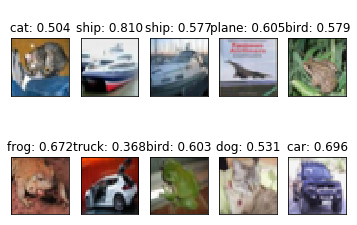

In [19]:
data = enumerate(dl.CIFAR10_test_loader).__next__()[1][0]
y = rs50(data.to(device))

#plotting.plot_samples([y, y2, y_base], data)
plotting.plot_samples([y], data, dataset='CIFAR10')

In [37]:
like = []
for data, label in dl.CIFAR10_test_loader:
    like.append(torch.logsumexp(gmm(data.view(-1, 3072)), 0))
like = torch.cat(like, 0)

In [38]:
like = torch.cat(like, 0)

In [36]:
data = enumerate(dl.CIFAR100_test_loader).__next__()[1][0]
torch.logsumexp(gmm(data.view(-1, 3072)), 0).mean()

tensor(0.3329, grad_fn=<MeanBackward1>)

In [41]:
likeE = []
for data, label in dl.CIFAR100_test_loader:
    likeE.append(torch.logsumexp(gmm(data.view(-1, 3072)), 0).detach())
likeE = torch.cat(likeE, 0)

TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

(array([   3.,   11.,   55.,  358.,  696., 1187., 2028., 2866., 2222.,
         574.]),
 array([-4.60620975, -3.98227682, -3.35834389, -2.73441095, -2.11047802,
        -1.48654509, -0.86261215, -0.23867922,  0.38525372,  1.00918665,
         1.63311958]),
 <a list of 10 Patch objects>)

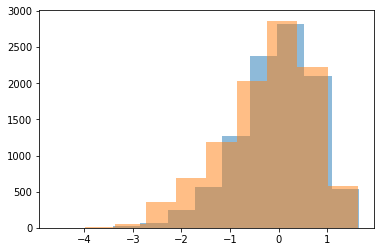

In [44]:
plt.hist(like.detach().cpu(),  alpha=.5)
plt.hist(likeE.detach().cpu(), alpha=.5)

In [42]:
likeE = torch.cat(likeE, 0)